## Setup

In [4]:
import os
PROJECT = 'pokoyakazan-test-01'
BUCKET = 'pokoyakazan-test-01'
REGION = 'us-central1'

os.environ['BUCKET'] = BUCKET

## Exploration using BQ

In [5]:
# setup BQ environment
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import google.cloud.bigquery as bigquery

bq = bigquery.Client()

In [8]:
sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001 AND dep_delay > -20 AND dep_delay < 30 AND distance < 2000
"""
df = bq.query(sql).to_dataframe()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


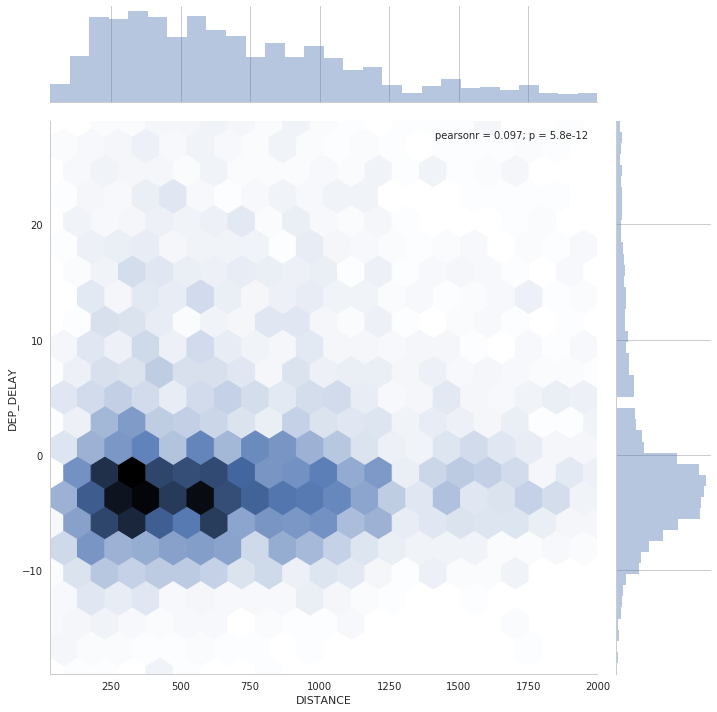

In [12]:
sns.set_style('whitegrid')
g = sns.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind="hex", size=10, joint_kws={'gridsize':20})

-> 出発遅延時間によるフライト数の変化は、フライト距離に依存しない
- -> 出発遅延時間とフライト数は独立な変数
- -> **各セルのフライト数を均等にするには、それぞれの変数について、境界値を個別に設定して構わない**

## Exploration using Spark SQL of Dataproc
- 以下の分析はBQでもできるが今回はSpark SQLをGCSから読み込んで使ってみる

In [14]:
# check
print(spark)

### Start a SparkSession

In [18]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bays classification using Spark") \
    .getOrCreate()
print(spark)

### Sparkで読み込むためのSchemaを定義

In [19]:
# Set up schema to read in the CSV files on GCS
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
  if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
    return StructField(colname, FloatType(), True)
  else:
    return StructField(colname, StringType(), True)
  
schema = StructType([get_structfield(colname) for colname in header.split(',')])
print(schema)

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,StringType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true)

-> ARR_DELAY', 'DEP_DELAY', 'DISTANCE'以外はStringTypeになっている

### SchemaとGCS上のcsvのPathを指定して読み込む

In [24]:
# Create a table definition (this is done lazily; the files won't be read until we issue a query)
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)
flights_csv = spark.read\
            .schema(schema)\
            .csv(inputs)

### 読み込んだデータからTempView作成

In [23]:
flights_csv.createOrReplaceTempView('flights.')

In [22]:
# check
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay > 20 AND distance < 2000')

AnalysisException: "Database 'default' not found;"